$$\huge\textbf{Implied Comparative Advantage - Offshoring}$$

In [21]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

import time, math
import matplotlib.mlab as mlab
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.iolib.summary2 import summary_col
from IPython.display import clear_output

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

$\textbf{Basic inputs}$

In [22]:
bad = ['Dem. Rep. of the Congo','Kuwait','Algeria','Saudi Arabia','United Arab Emirates',
       'Angola','Azerbaijan','Curaçao',]
Países = ['Brunei Darussalam', 'Peru', 'Greece', 'Slovakia', 'Thailand', 'Denmark', 'Austria', 'Slovenia', 
          'Finland', 'Belgium', 'Germany', 'Spain', 'Korea', 'Philippines', 'Hungary', 'Viet Nam', 'South Africa',
          'Brazil', 'Argentina', 'India', 'Lithuania', 'United Kingdom', 'Canada', 'Netherlands', 
          'Russian Federation', 'Poland', 'Italy', 'Colombia', 'Mexico', 'Cambodia', 'Switzerland', 'Morocco', 
          'Norway', 'Japan', 'Croatia', 'Luxembourg', 'Tunisia', 'Turkey', 'USA', 'Czechia', 'Sweden', 'Latvia',
          'Malta', 'Singapore', 'Bulgaria', 'Portugal', 'Iceland', 'Romania', 'Saudi Arabia', 'Chile', 'Estonia', 
          'France', 'China, Hong Kong SAR', 'China', 'Australia', 'Ireland', 'New Zealand', 'Malaysia', 
          'Costa Rica', 'Indonesia', 'Cyprus', 'Israel']

Developed=['Austria','Belgium','Denmark','Finland','France','Germany','Greece','Ireland','Italy','Luxembourg',
'Netherlands','Portugal','Spain','Sweden','United Kingdom','Bulgaria','Croatia','Cyprus','Czechia','Estonia',
'Hungary','Latvia','Lithuania','Malta','Poland','Romania','Slovakia','Slovenia','Iceland','Norway','Switzerland',
'Australia','Canada','Japan','New Zealand','USA']

Nondevel=[t for t in Países if t not in Developed]

industries = [i for i in range(1,35)]
pop_cols = ['Country Name'] + [str(t) for t in range(1995,2012)]

names = industries.copy()
names.insert(0,'Países\Industrias')

In [23]:
dir1 = '...'
dir2 = '...'

$\textbf{Basic functions}$

In [24]:
def multiply(a, b):
    return [ a[l]*b[l] for l in range(len(a))]
def index_error(off):
    try:
        off.set_index('Países\Industrias', inplace = True)
    except KeyError:
        pass

In [25]:
def open_f(year):
    global panel
    panel = pd.read_excel(dir1+'panel' + str(year)  + '.xlsx')
    panel = panel[ panel['Países\Industrias'].isin(pop['Country Name']) ]

pop = pd.read_excel(dir1 + 'World_pop.xls', skiprows=3)[pop_cols]

In [7]:
# No usar
au = []
for y in range(1995,2012):
    open_f(y)
    au.extend([t for t in panel['Importer'] if t not in list(pop['Country Name'])])
    au.extend([t for t in panel['Países\Industrias'] if t not in list(pop['Country Name'])])
m = set(au)
print(m)

set()


$\huge\textbf{Product Space}$

$\textbf{Industry similarities}$

$*$ We have to normalize the data by population, for some reason later defined functions stop working when we do this. 
Check it out this later

In [6]:
def normalize_pop():
    global off
    off = off.sort_values(by = ['Países\Industrias'] , ascending = True )

    pop_sub = pop[pop['Country Name'].isin(off[off.columns[0]])]
    pop_sub = pop_sub.sort_values(by = ['Country Name'] , ascending = True )
    s_pop_l = pop[year].sum()

    for i in off.columns[1:]:
        W_i = pop_sub[year]*(off[i].sum()/s_pop_l)
        off[i] = off[i]/list(W_i)

$*$ With this function we construct the similarities matrices using correlation per industry. There are two inputs with the following specifications: (origin, ) = group by origin and (destination, ) = group by destination. Additionally, (country, destination) = country of origin vs rest of the world and (country, else) = All importer vs country. 

In [6]:
def filter_panel(country, ori_dest):
    global off
    
    if country == 'origin':
        off = panel.groupby(['Importer'], as_index=False).agg({i: 'sum' for i in range(1,35)})
    elif country == 'destination':
        off = panel.groupby(['Países\Industrias'], as_index=False).agg({i: 'sum' for i in range(1,35)}) #1
    else:
        if ori_dest == 'destination':
            off = panel[panel['Importer'] == country]
            off = off.drop(['Importer'], axis = 1)
        else:
            off = panel[panel['Países\Industrias'] == country]
            off = off.drop(['Países\Industrias'], axis = 1)
    
    off.columns = ['Países\Industrias'] + [i for i in range(1,35)]
    
    off = off[ (off[[i for i in range(1,35)]].T!= 0).any() ]  #2

def sim_industry_f():    
    global sim_industry , k
    
    sim_industry , k = pd.DataFrame() , 5
    sim_industry['Industry'] = pd.Series(industries)

    for code1 in industries:
        col1 , au = off[code1] , []
        for code2 in industries:
            col2 = off[code2]
            au.append( (1+np.corrcoef(col1 , col2)[0][1])/2 ) 
        sim_industry[code1] = pd.Series(au)
    sim_industry = sim_industry.fillna(0)
    return sim_industry.head()

$#1$ Recordar filtrar en algo punto por todos aquellos países que sí sean comunes a todos los importadores $$$$
$#2$ Líneas extra: normalize_pop(), k = math.ceil(len(off)*2/7)

$\textbf{k-nearest neighbours}$

$*$ We obtain the k nearest neighbours, for industries we are using k = 5

In [7]:
def nearest_neigh(similarities ,k , codes ):
    global weights , selected_codes
    weights , selected_codes = {} , {}
    for code in codes:
        d = similarities[[similarities.columns[0] ,code ]].sort_values(by = [code], ascending = False )
        d = d[d[similarities.columns[0]] != code ]
        d = d[:k]
        d[[code]] = d[[code]]/d[code].sum()
        d = d.fillna(0)
        selected_codes[code] , weights[code] =  list(d[similarities.columns[0]]) , list(d[code])
        selected_codes[code].insert(0, 'Países\Industrias')

In [8]:
def Y_ij_gorro_I(off):
    global final
    final = { 'out': pd.DataFrame(), 'in': off.copy() } 
    states =  list(final['in']['Países\Industrias'])
    for n in names:
        final['out'][n] = pd.Series([])
    final['out']['Países\Industrias'] = pd.Series(states)
    
    for code in industries:
        data , au_code = final['in'] , []
        data = data[ selected_codes[code] ]
                
        for s in states:
            m = list(data[data['Países\Industrias'] == s].values[0][1:])
            au_code.append( sum(multiply(m, weights[code])) )
        final['out'][code] = pd.Series( au_code )
    
    return final['out'].head()

$*$ Results:

In [158]:
year = '1995'
open_f(year)
filter_panel('Colombia', 'destination')
sim_industry_f()
nearest_neigh(sim_industry , k , industries)
Y_ij_gorro_I(off)

,Países\Industrias,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,Zimbabwe,4.472633e+00,3.695524e+00,1.050743e+00,1.769436e+01,1.511124e+02,3.112894e+00,8.949689e-01,2.004070e+01,2.042091e+01,...,1.354444e+02,1.217029e+01,1.222738e+01,1.216277e+01,1.217131e+01,5.874619e+00,1.209693e+01,2.188750e+01,1.321625e+00,0.0
1,Russian Federation,4.042366e+06,4.601879e+06,3.144183e+06,3.841700e+06,3.867045e+06,2.938567e+06,2.813130e+06,3.622367e+06,4.770569e+06,...,7.012136e+06,1.356473e+05,4.641196e+05,1.346232e+05,9.378928e+04,1.537887e+06,4.134956e+05,1.818308e+06,6.668311e+05,0.0
2,USA,2.105263e+08,2.763325e+08,1.446259e+08,2.799729e+08,1.735943e+08,2.637112e+08,2.711903e+08,1.783008e+08,2.224358e+08,...,1.661356e+08,5.669450e+07,7.016337e+07,5.284315e+07,4.564052e+07,1.484394e+08,8.069019e+07,1.493002e+08,1.219086e+08,0.0
3,Comoros,2.219837e+01,1.834146e+01,5.215001e+00,8.781982e+01,7.499941e+02,1.544977e+01,4.441869e+00,9.946510e+01,1.013521e+02,...,6.722312e+02,6.040301e+01,6.068635e+01,6.036568e+01,6.040810e+01,2.915664e+01,6.003892e+01,1.086310e+02,6.559427e+00,0.0
4,Viet Nam,2.382750e+04,2.929460e+04,1.682787e+04,2.395588e+04,3.859654e+04,2.042402e+04,1.623530e+04,2.891785e+04,3.332395e+04,...,4.642164e+04,1.081481e+04,1.230200e+04,1.082073e+04,9.673913e+03,1.432519e+04,1.240170e+04,2.036707e+04,6.843024e+03,0.0


$*$ The following functions are meant to put together the output of the previous functions, in order to build panel data.

In [9]:
panel_est = pd.DataFrame()
def add_col_country(final, country):
    global au
    au = pd.DataFrame({'Importer': [country for t in range(len(final))] })
    au = pd.concat([au , final], axis = 1 )
    
panel_est_time = pd.DataFrame()
def add_col_year(panel_est, year):
    au2 = [year for t in range(len(panel_est))]
    panel_est.insert(0, 'Year' , au2 )

$*$ With the following cell we calculate $\hat{Y}^{[I]}_{ij}$ for each (country, destination) and build a new panel.

In [96]:
panel_est_time = pd.DataFrame()
for year in range(1995,2012):
    panel_est = pd.DataFrame()
    open_f( year )
    
    for c in Países:
        filter_panel( c , 'destination' )
        sim_industry_f()
        nearest_neigh(sim_industry , k , industries)
        Y_ij_gorro_I(off)                                #off for each country c                
        add_col_country(final['out'], c)                 #adjoint a new column
        panel_est = panel_est.append(au)                 #append it to file. 
    
    add_col_year(panel_est , year)
    panel_est_time = panel_est_time.append(panel_est)

panel_est_time.to_excel(dir1 + 'panel_implied_ind.xlsx', index = False )

In [ ]:
#No usar
for i in range(100):
    clear_output()
    print(i)
    Y_ij_gorro(final['out'])

$\huge\textbf{Country Space}$

$\textbf{Country similarities}$

In [10]:
def sim_country_f():    
    global sim_country , k , codes , off_c
    
    index_error(off)
    off_c = off.transpose()
    sim_country , k , codes = pd.DataFrame() , math.ceil(len(off)*0.25) , list(off_c.columns.copy())
    sim_country['Country'] = pd.Series(codes)
    off_c.insert(0, 'Países\Industrias' , off_c.index )

    for code1 in codes:
        col1 , au = off_c[code1] , []
        for code2 in codes:
            col2 = off_c[code2]
            au.append( (1+np.corrcoef(col1 , col2)[0][1])/2 ) 
        sim_country[code1] = pd.Series(au)
    sim_country = sim_country.fillna(0)
    return sim_country.head()

In [11]:
def Y_ij_gorro_L(off):
    global final2
    final2 = { 'out': pd.DataFrame(), 'in': off.copy() } 
    ind =  list(final2['in']['Países\Industrias'])
    for n in ['Países\Industrias'] + codes:
        final2['out'][n] = pd.Series([])
    final2['out']['Países\Industrias'] = pd.Series(ind)
    
    for code in codes:
        data , au_code = final2['in'] , []
        data = data[ selected_codes[code] ]
                
        for s in ind:
            m = list(data[data['Países\Industrias'] == s].values[0][1:])
            au_code.append( sum(multiply(m, weights[code])) )
        final2['out'][code] = pd.Series( au_code )
    
    for dframe_name in final2.keys():
        index_error(final2[ dframe_name ])
        final2[ dframe_name ] = final2[ dframe_name ].transpose()
        final2[ dframe_name ].insert(0, 'Países\Industrias' , final2[ dframe_name ].index )
        final2['out'] = final2['out'].reset_index(drop=True)
    return final2['out'].head()

In [98]:
year = '1995'
open_f(year)

$*$ Results:

In [159]:
filter_panel('Colombia', 'destination')
sim_country_f()
nearest_neigh(sim_country , k , codes)
Y_ij_gorro_L(off_c)

Países\Industrias,Países\Industrias,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,Zimbabwe,1.895424e+05,8.964015e+04,5.362214e+05,1.205915e+05,23407.412158,1.506702e+05,1.271810e+05,3.197445e+05,1.264251e+05,...,2.540932e+04,3968.023768,564.387987,15052.563922,3.777632e+04,1.281562e+05,16862.448577,1.235103e+05,4.370345e+04,0.0
1,Russian Federation,4.376840e+06,3.830979e+06,8.784224e+06,2.866967e+06,654450.762341,3.950083e+06,3.830432e+06,9.672354e+06,3.994695e+06,...,9.267873e+05,106891.303804,4831.610480,307617.788848,1.034717e+06,3.006292e+06,407720.309173,3.101008e+06,9.962087e+05,0.0
2,USA,6.750241e+06,6.547851e+06,1.202122e+07,5.097675e+06,631384.043084,7.171293e+06,7.711071e+06,1.456923e+07,6.156675e+06,...,1.230898e+06,244046.678855,9487.115281,792653.176325,2.039498e+06,6.456909e+06,819538.009819,5.966200e+06,2.137653e+06,0.0
3,Comoros,1.895297e+05,8.964012e+04,5.361172e+05,1.205894e+05,23404.726980,1.506696e+05,1.271810e+05,3.197441e+05,1.264250e+05,...,2.540932e+04,3968.023768,564.387987,15052.563922,3.777632e+04,1.281552e+05,16862.388236,1.235100e+05,4.370188e+04,0.0
4,Viet Nam,4.417030e+06,3.956543e+06,9.043206e+06,2.901176e+06,664216.802147,4.004944e+06,3.804012e+06,9.840294e+06,4.075294e+06,...,9.699426e+05,106361.604865,4829.074854,306553.399333,1.037231e+06,3.036434e+06,409724.619992,3.110573e+06,9.966347e+05,0.0


$*$ With the following cell we calculate $\hat{Y}^{[L]}_{ij}$ for each (country, destination) and build a new panel.

In [13]:
panel_est_time = pd.DataFrame()
for year in range(1995,2012):
    panel_est  = pd.DataFrame()
    open_f( year )
    
    for c in Países:             
        filter_panel( c , 'destination' )
        sim_country_f()
        nearest_neigh(sim_country , k , codes)
        Y_ij_gorro_L(off_c)                        #off for each country c                                     
        add_col_country(final2['out'], c)          #adjoint a new column
        panel_est = panel_est.append(au)           #append it to file. 
    
    add_col_year(panel_est , year)
    panel_est_time = panel_est_time.append(panel_est)

panel_est_time.to_excel(dir1 + 'panel_implied_country.xlsx', index = False )

$\huge\textbf{Regression analysis}$

$*$ Regression analysis per (country , destination)

In [15]:
X_n, Z_n = 'Product space density', 'Country space density'
def lin_reg(f1, f2, var):
    global X , Y, model, data
    
    f = pd.merge(f1['out'], f2['out'] ,  on = 'Países\Industrias' )
    X, Y, Z = ([] for i in range(3))
    
    for code in industries:
        Y.extend( list(final['in'][code]) )
        X.extend( list(f[ str(code)+'_x' ]) )
        Z.extend( list(f[ str(code)+'_y' ]) )
    
    data = pd.DataFrame({'Y': Y, X_n: X, Z_n:Z})
    data['Y'], data[X_n], data[Z_n] = data['Y'].astype(float), data[X_n].astype(float), data[Z_n].astype(float)
    data = data[ (data[X_n]!=0) & (data['Y']!=0) & (data[Z_n]!=0) ]
    data = data.apply(np.log)
    
    Y, X = data.Y , data[var]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()

    return model
    #return print(model.summary())

In [17]:
print(lin_reg(final, final2, [X_n,Z_n]).summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                 1.668e+04
Date:                Sat, 07 Apr 2018   Prob (F-statistic):               0.00
Time:                        12:44:41   Log-Likelihood:                -8242.0
No. Observations:                4359   AIC:                         1.649e+04
Df Residuals:                    4356   BIC:                         1.651e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -8.06

$*$ Histogram of errors.

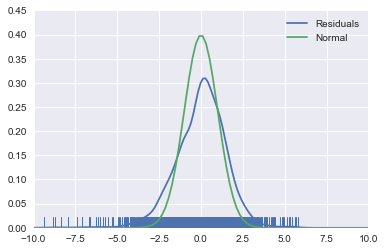

In [90]:
e = Y-model.predict(X)
sns.distplot(e, hist=False, rug=True , label = 'Residuals')
x = np.linspace(-10, 10, 100)
plt.plot(x , mlab.normpdf(x, 0, 1), label='Normal')
plt.axis([-10, 10, 0, 0.45]), plt.legend()
plt.show()

$*$ Regression analysis for 3 Latin American countries

In [15]:
year = '2011'
open_f(year)

In [69]:
delete = ['\caption{}\n', '\\begin{center}\n', '\\end{center}\n', '\\begin{table}\n', '\n\\end{table}']

def latex_table(c, f):
    global res, text
    info_dict={'R2' : lambda x: '{:.2f}'.format(x.rsquared),
               'No. observaciones' : lambda x: '{:.0f}'.format(int(x.nobs)) }

    m3 = lin_reg(final, final2, [X_n,Z_n])
    m1 = lin_reg(final, final2, [X_n])
    m2 = lin_reg(final, final2, [Z_n])
    res = summary_col([m1,m2,m3],stars=True, float_format='%0.3f', model_names=['(1)', '(2)', '(3)'], 
                          regressor_order = [X_n , Z_n], info_dict=info_dict)
    text = res.as_latex()
    for l in delete:
        text = text.replace(l,'')
    
    text = text[text.index('Product')-22:]
    text = text.replace('{llll}','{llll}\n \\hline & (1) & (2) & (3) \\\\')
    text = text.replace('\nProduct','\n \\hline \n Product')
    text = text.replace('\\begin{tabular}','\\resizebox{0.95\\linewidth}{!}{%\n\\begin{tabular}')
    text = text.replace('\end{tabular}','\end{tabular}%\n}')
    
    #text = text.replace('\\resizebox{0.95','\\begin{flushright}\n\\resizebox{0.40',1)
    #text = text.replace('\end{tabular}%\n}','\end{tabular}%\n}\n\\end{flushright}\n',1)
    
    with open(dir2+'Tablas\\'+ c + f +'.tex','w', encoding='utf-8') as tf:
        tf.write(text)

In [71]:
latex_table(c , 'destination')
#for l in delete:
#    text = text.replace(l,'')
text

'\\resizebox{0.95\\linewidth}{!}{%\n\\begin{tabular}{llll}\n \\hline & (1) & (2) & (3) \\\\\n \\hline \n Product space density & 1.027***  &           & 0.911***   \\\\\n                      & (0.007)   &           & (0.006)    \\\\\nCountry space density &           & 1.292***  & 0.560***   \\\\\n                      &           & (0.027)   & (0.013)    \\\\\nconst                 & -1.068*** & -9.545*** & -8.063***  \\\\\n                      & (0.076)   & (0.403)   & (0.169)    \\\\\nR2                    & 0.83      & 0.34      & 0.88       \\\\\nNo. observaciones     & 4359      & 4359      & 4359       \\\\\n\\hline\n\\end{tabular}%\n}'

In [72]:
countries = ['Colombia', 'Brazil', 'Argentina']
flow = ['origin' , 'destination']
for f in flow:
    for c in countries:
        filter_panel( c , f)
        sim_country_f()
        nearest_neigh(sim_country , k , codes)
        Y_ij_gorro_L(off_c)

        filter_panel( c , f)
        sim_industry_f()
        nearest_neigh(sim_industry , k , industries)
        Y_ij_gorro_I(off)

        latex_table(c, f)

$\huge\textbf{TeX tables}$

$*$The following is just to extract most similar pairs of industries and countries, this is info included in the thesis

In [30]:
year = '2011'
open_f(year)

$*$Most related sectors:

In [33]:
countries = {'Colombia':[], 'Argentina':[], 'Brazil':[]}
names = pd.read_excel(dir1+'industries_names.xlsx')
names = {names.loc[t].values[0]:names.loc[t].values[1] for t in range(0,34)}
for c in countries.keys():
    #filter_panel(c, 'destination')
    filter_panel(c, 'origin')
    sim_industry_f()
    
    for i in sim_industry.columns[1:]:
        for j in list(sim_industry[i]):
            if list(sim_industry[i]).index(j)+1 > i:
                l = list(sim_industry[i]).index(j)+1
                countries[c].append(( names[i],names[l],round(j,4) ))
    
    countries[c] = [t for t in countries[c] if t[-1]!=1]
    countries[c].sort(key=lambda tup: tup[-1], reverse=True)
    countries[c] = countries[c][:3]

$*$ Most related countries:

In [41]:
countries = {'Colombia':[], 'Argentina':[], 'Brazil':[]}

for c in countries.keys():
    filter_panel(c, 'destination')
    #filter_panel(c, 'origin')
    sim_country_f()
    
    for i in sim_country.columns[1:]:
        for j in range(len(sim_country)):
            if j > list(sim_country.columns[1:]).index(i):
                l = sim_country[['Country',i]].iloc[j].values[0:2]
                countries[c].append(( i , l[0], round(l[1],4) ))

    countries[c] = [t for t in countries[c] if t[-1]!=1]
    countries[c].sort(key=lambda tup: tup[-1], reverse=True)
    countries[c] = countries[c][3:6]

In [42]:
s = pd.DataFrame()
for c in countries.keys():
    s = s.append( [(c,'-','-')] ) 
    s = s.append( pd.DataFrame(countries[c]) )
#s.columns = ['Sector i', 'Sector j', 'Corr i-j']
s.columns = ['País m', 'País n', 'Corr m-n']

with open(dir2+'Tablas\\Phi_P'+'.tex','w', encoding='utf-8') as tf:
    text = s.to_latex(index=False)
    text = text.replace('\\begin{tabular}','\\resizebox{0.4\\linewidth}{!}{%\n\\begin{tabular}')
    text = text.replace('\end{tabular}','\end{tabular}%\n}')
    tf.write(text)

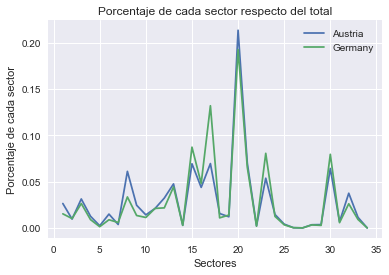

In [374]:
filter_panel('Colombia', 'destination')
d = off[off['Países\Industrias'].isin(['Germany','Austria'])]
for i in range(len(d)):
    #plt.plot(range(1,35),[np.log(t) for t in d.iloc[i][1:]], label=d.iloc[i][0])
    plt.plot(range(1,35),[t/sum(d.iloc[i][1:]) for t in d.iloc[i][1:]], label=d.iloc[i][0])
plt.title('Porcentaje de cada sector respecto del total')
plt.xlabel('Sectores'),plt.ylabel('Porcentaje de cada sector'), plt.legend()
plt.savefig(dir2+'Imagenes\\Ger-Aus'+'.pdf', format='pdf', dpi=1000)

plt.show()

$\huge\textbf{Panel regression}$

In [8]:
panel_f = pd.DataFrame()
for year in range(1995,2012):
    d = pd.read_excel(dir1 + 'panel' + str(year) + '.xlsx')
    au = [year for t in range(len(d))]
    d.insert(0, 'Year', au)
    panel_f = panel_f.append(d)

panel_f.to_excel(dir1 + 'panel.xlsx', index = False)

In [9]:
panel_f = pd.read_excel(dir1 + 'panel.xlsx')
panel_f = panel_f[ panel_f['Países\Industrias'].isin(pop['Country Name']) ]
panel_f.to_excel(dir1 + 'panel.xlsx', index = False)

In [26]:
panel_f = pd.read_excel(dir1 + 'panel.xlsx')
panel_ind = pd.read_excel(dir1 + 'panel_implied_ind.xlsx')
panel_cou = pd.read_excel(dir1 + 'panel_implied_country.xlsx')

In [27]:
cols = ['Año' , 'Origen', 'Destino' ,'Industria' ,'Offshoring']

data = [panel_f, panel_ind, panel_cou]
frames = [[], [], []]

for k in range(3):
    d1 = data[k].reset_index(drop=True)

    for row in d1.values.tolist():
        i = 1
        for cell in row[3:]:
            frames[k].append(row[0:3]+[ i , cell])
            i = i+1
    frames[k] = pd.DataFrame(frames[k])
    frames[k].columns = cols

In [29]:
len(panel_f),  len(panel_ind), len(frames[0]), len(frames[1])

(179475, 147589, 6102150, 5018026)

In [30]:
for df in frames:
    df[['Año']] = df[['Año']].astype(str)
    df[['Industria']] = df[['Industria']].astype(str)
    df['Key'] = df[['Año', 'Origen', 'Destino', 'Industria']].apply(lambda x: ''.join(x), axis=1)

In [31]:
f = frames[1].set_index('Key').join(frames[2].set_index('Key'), lsuffix='_1', rsuffix='_2')
f = f[['Año_1', 'Origen_1', 'Destino_1', 'Industria_1','Offshoring_1', 'Offshoring_2']]
f = f.join(frames[0].set_index('Key'))
f = f[['Año', 'Origen', 'Destino' , 'Industria', 'Offshoring', 'Offshoring_1', 'Offshoring_2']]
f.head()

,Año,Origen,Destino,Industria,Offshoring,Offshoring_1,Offshoring_2
Key,,,,,,,
1995PeruRussian Federation1,1995,Peru,Russian Federation,1,1.077261e+05,131392.563620,5.772573e+06
1995PeruRussian Federation2,1995,Peru,Russian Federation,2,4.724163e+04,98414.864874,4.337162e+06
1995PeruRussian Federation3,1995,Peru,Russian Federation,3,1.155941e+06,152784.472351,6.663921e+06
1995PeruRussian Federation4,1995,Peru,Russian Federation,4,3.368572e+05,276858.705139,3.763648e+06
1995PeruRussian Federation5,1995,Peru,Russian Federation,5,4.149868e+04,29168.030006,2.477838e+06


In [32]:
len(frames[0]), len(frames[1]), len(f)

(6102150, 5018026, 5018026)

In [33]:
f[['Año']] = f[['Año']].astype(np.int64)
f[['Industria']] = f[['Industria']].astype(np.int64)

In [34]:
f = f.reset_index(drop=True)
#f.to_stata(dir1 + 'panel_full.dta', index=False)
f.to_excel(dir1 + 'panel_full.xlsx', index=False)

In [35]:
f.to_pickle(dir1 + 'panel_full.pkl')

In [37]:
f.to_csv(dir1 + 'panel_full.csv', index=False , sep = ';')

$\textbf{Estimations}$

In [119]:
from linearmodels import PooledOLS, PanelOLS

In [140]:
f['Año'] =  f['Año'].astype(np.int64)
for n in ['Offshoring', 'Offshoring_1', 'Offshoring_2']:
    f[n] =  f[n].astype(float)
f = f[ (f['Offshoring']!=0) & (f['Offshoring_1']!=0) & (f['Offshoring_2']!=0) ]
data = f.copy()
data = data.set_index(['Origen', 'Destino' , 'Año'])
data = data[['Offshoring', 'Offshoring_1', 'Offshoring_2']]
data = data.apply(np.log)

Y, X = data[['Offshoring']] , data[['Offshoring_1', 'Offshoring_2']]
X = sm.add_constant(X)

In [157]:
#mod = PanelOLS(data.Offshoring, data[['Offshoring_1', 'Offshoring_2']])
#res = mod.fit(cov_type='clustered', cluster_entity=True)
#print(res.summary())